# TITLE

## Purpouse

#### Importing 3rd party libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

import geopandas as gpd
import contextily as ctx
from geopy.distance import great_circle

from shapely.geometry import Point

import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits.basemap import Basemap

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import lasso_path
import xgboost
import shap

## BERLIN

#### Loading  dataset

In [2]:
data = pd.read_csv('listings_summary.csv')


print(f'Dataset contains {data.shape[0]} rows and {data.shape[1]} columns')
print(f'Dataset number of duplicates in the dataset {data.duplicated().sum()}')
print()
print(data.columns)

Dataset contains 22552 rows and 96 columns
Dataset number of duplicates in the dataset 0

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
   

#### After the review of the columns, we decided to keep the following columns which we believe will be important in our study.

In [3]:
selected_columns = ['id','host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'beds','amenities', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy','host_is_superhost']

#### Dropping redudant columns and crate a new dataset.

In [4]:
# getting new dataframe
dataset = data[selected_columns].set_index('id')
print(f'Dataset contains {dataset.shape[0]} rows and {dataset.shape[1]} columns')

Dataset contains 22552 rows and 23 columns


Brief check of the dataset

In [5]:
# initializing new data frame that will be displayed in the table
data_review = pd.DataFrame(columns = ['Column','Data Type','Misssing Values', '[%] Missing Values', 'Sum Unique Val'])

# looping via columns and extracting needed information
for index, column in enumerate(dataset.columns):
    data_type = dataset.dtypes[column]
    missing_value = dataset[column].isnull().sum()
    percentage = round((missing_value/len(dataset))* 100,1) if (missing_value/len(dataset))* 100 else 0
    unique_val = len(dataset[column].unique())
    data_review.loc[index] = [column, data_type, missing_value,percentage,unique_val]
    
data_review.head(len(data_review)) # show table

,Column,Data Type,Misssing Values,[%] Missing Values,Sum Unique Val
0,description,object,203,0.9,21998
1,host_has_profile_pic,object,26,0.1,3
2,neighbourhood_group_cleansed,object,0,0.0,12
3,latitude,float64,0,0.0,22552
4,longitude,float64,0,0.0,22552
5,property_type,object,0,0.0,33
6,room_type,object,0,0.0,3
7,accommodates,int64,0,0.0,16
8,bathrooms,float64,32,0.1,17
9,bedrooms,float64,18,0.1,13


### Cleaning the column with prices

In [6]:
price_columns = ['price', 'cleaning_fee', 'extra_people', 'security_deposit']
dataset[price_columns].head(5)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
2015,$60.00,$30.00,$28.00,$200.00
2695,$17.00,$0.00,$0.00,$0.00
3176,$90.00,$50.00,$20.00,$200.00
3309,$26.00,$30.00,$18.00,$250.00
7071,$42.00,$0.00,$24.00,$0.00


We see that 31.7 % rows in the dataset have null values in the 'cleaning_fee' column. We assume that those places do not charge for cleaning. We replace NULL vales with 0.

In [7]:
dataset['cleaning_fee'].fillna('$0.00', inplace=True)

We proceed the same way with the 'security deposit'. Assuming that NULL values represent places where the deposit is not required, we can state that there are 41.5% of such hosts.

In [8]:
dataset['security_deposit'].fillna('$0.00', inplace=True)

In [9]:
# again, checking for null values 
dataset[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].isna().sum() 

price               0
cleaning_fee        0
extra_people        0
security_deposit    0
dtype: int64

#### Convering the price columns to float type

In [10]:

for col in price_columns:
    dataset[col] = dataset[col].apply(lambda x: x.replace("$", ""))
    dataset[col] = dataset[col].apply(lambda x: x.replace(",", "")).astype("float")
    
print(dataset[price_columns].head(5))

dataset[price_columns].describe()


      price  cleaning_fee  extra_people  security_deposit
id                                                       
2015   60.0          30.0          28.0             200.0
2695   17.0           0.0           0.0               0.0
3176   90.0          50.0          20.0             200.0
3309   26.0          30.0          18.0             250.0
7071   42.0           0.0          24.0               0.0


,price,cleaning_fee,extra_people,security_deposit
count,22552.000000,22552.000000,22552.000000,22552.000000
mean,67.143668,18.253991,8.257716,118.284454
std,220.266210,28.172816,11.151069,304.232661
min,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,0.000000,0.000000
50%,45.000000,10.000000,5.000000,0.000000
75%,70.000000,30.000000,15.000000,150.000000
max,9000.000000,2000.000000,250.000000,4280.000000


#### Visualizing price with Boxplot

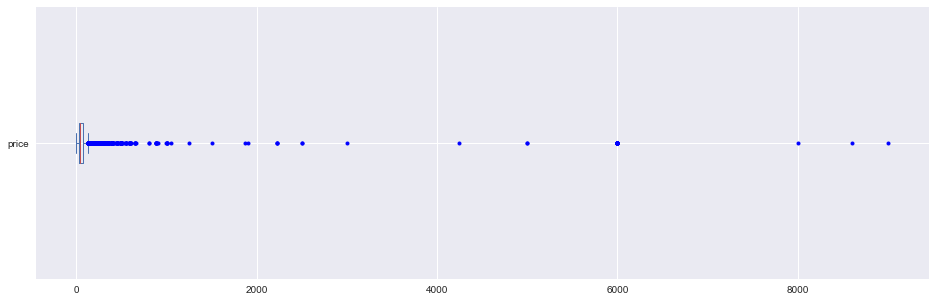

In [11]:
box = dict(markerfacecolor='b', markeredgecolor='b', marker='.')
dataset['price'].plot(kind='box', vert=False, flierprops=box, figsize=(16,5))

#### Removing outliers within the price column
We remove the last 0.5% observation with highest prices

In [12]:
dataset = dataset[(dataset.price <= np.percentile(dataset.price, 99.5)) & (dataset.price > 0)]
dataset['price'].describe()

count    22441.000000
mean        57.584377
std         42.162006
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        400.000000
Name: price, dtype: float64

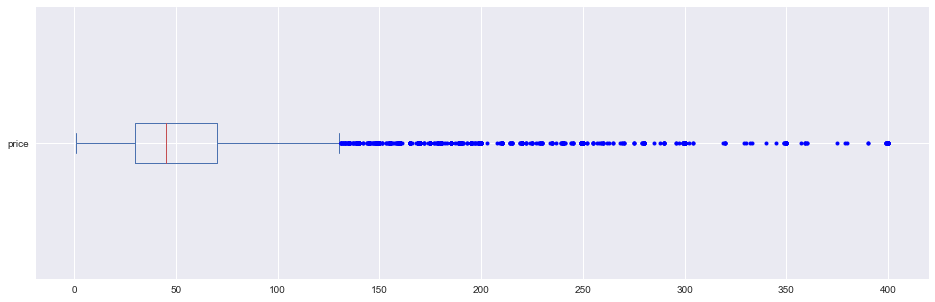

In [13]:
dataset['price'].plot(kind='box', vert=False, flierprops=box, figsize=(16,5))

### Exploring and analyzing dataset based on the location of Airbnb in Berlin

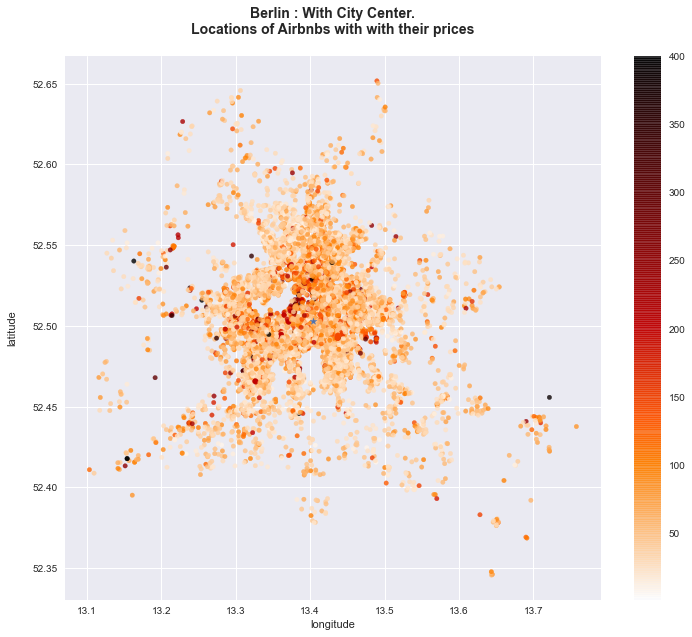

In [14]:
# using mapplotlib scatterplot 
berlin_centre = (52.5027778, 13.404166666666667)
fig = plt.figure(figsize = (12, 10))
plt.scatter(x=dataset["longitude"], y=dataset["latitude"],c=dataset["price"], cmap='gist_heat_r',s=20,alpha=0.8)
plt.colorbar()
ploted_center = plt.scatter(berlin_centre[1], berlin_centre[0], marker='*')
plt.xlabel('longitude')
plt.ylabel('latitude\n')
plt.title('Berlin : With City Center.\nLocations of Airbnbs with with their prices\n', fontsize=14, fontweight='bold')
plt.show()

Same idea but done with geopandas & contextily


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


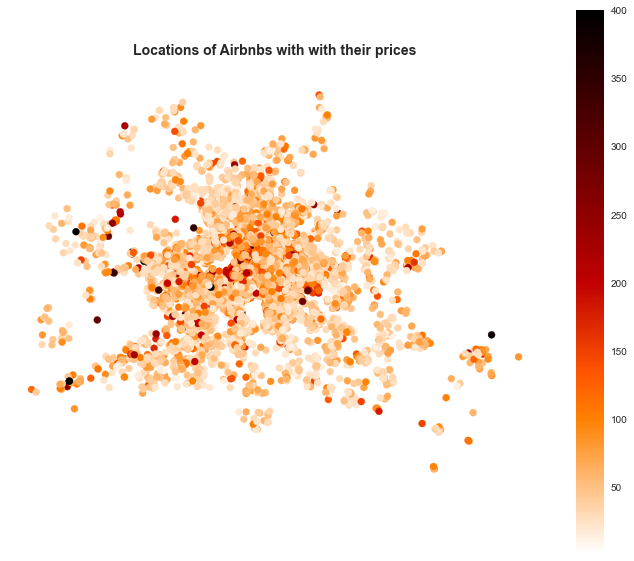

In [15]:
def add_basemap(ax, zoom):
    xmin, xmax, ymin, ymax = ax.axis()
    ax.axis((xmin, xmax, ymin, ymax))

# Let's define our raw data, whose epsg is 4326
df = dataset[["longitude","latitude","price"]]
df['coords'] = list(zip(dataset["longitude"], dataset["latitude"]))

# ... turn them into geodataframe, and convert our
# epsg into 3857, since web map tiles are typically
# provided as such.
geo_df = gpd.GeoDataFrame(
    df, crs  ={'init': 'epsg:4326'},
    geometry = df['coords'].apply(Point)
).to_crs(epsg=3857)

# ... and make the plot
ax = geo_df.plot(
    figsize= (12, 10),
    column= "price",
    cmap = "gist_heat_r",
    legend=True
)
ax.set_axis_off()
plt.title('Locations of Airbnbs with with their prices\n', fontsize=14, fontweight='bold')

plt.show()

And the same one but this time with a basemap


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


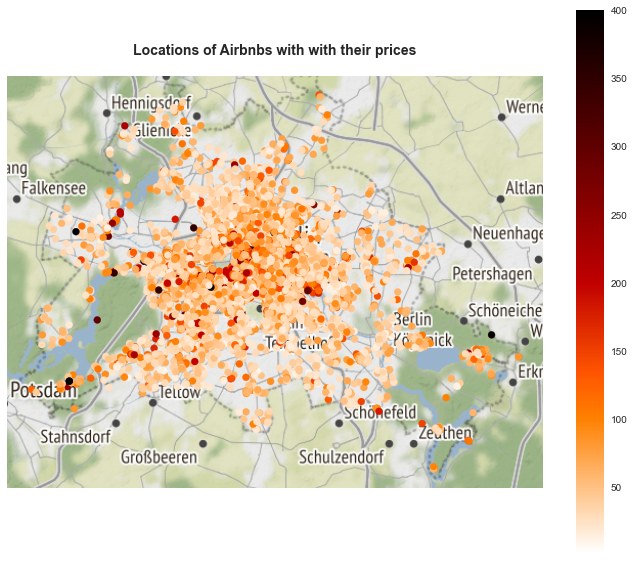

In [16]:
def add_basemap(ax, zoom):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    ax.axis((xmin, xmax, ymin, ymax))

# Let's define our raw data, whose epsg is 4326
df = dataset[["longitude","latitude","price"]]
df['coords'] = list(zip(dataset["longitude"], dataset["latitude"]))

# ... turn them into geodataframe, and convert our
# epsg into 3857, since web map tiles are typically
# provided as such.
geo_df = gpd.GeoDataFrame(
    df, crs  ={'init': 'epsg:4326'},
    geometry = df['coords'].apply(Point)
).to_crs(epsg=3857)

# ... and make the plot
ax = geo_df.plot(
    figsize= (12, 10),
    column= "price",
    cmap = "gist_heat_r",
    legend=True
)
add_basemap(ax, 10)
ax.set_axis_off()
plt.title('Locations of Airbnbs with with their prices\n', fontsize=14, fontweight='bold')

plt.show()

### Distance to the city center of Berlin, Neighborhoods and Prices

Creating a new column to keep the distance between an Airbnb location and the city center of Berlin. Distance is given in km.

In [17]:
def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    AirBnB = (lat, lon)
    return great_circle(berlin_centre, AirBnB).km

dataset['distance'] = dataset.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [18]:
dataset['distance'].describe()

count    22441.000000
mean         4.549413
std          2.665971
min          0.198956
25%          2.979685
50%          4.088786
75%          5.552481
max         25.012109
Name: distance, dtype: float64

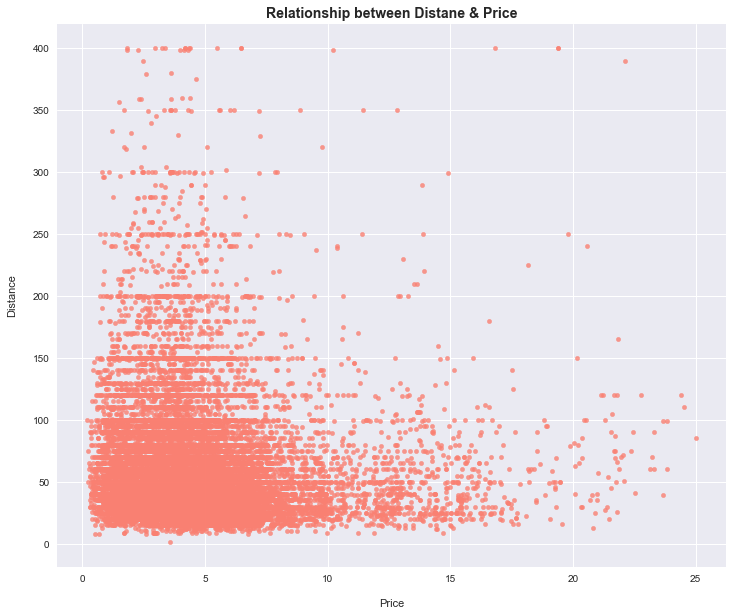

In [19]:
fig = plt.figure(figsize = (12, 10))
plt.scatter(x=dataset["distance"], y=dataset["price"],  c=['#fa8072'],s=20,alpha=0.8)

plt.title('Relationship between Distane & Price', fontsize=14, fontweight='bold')
plt.xlabel('\nPrice')
plt.ylabel('Distance\n')
plt.show()

Same idea but using a diffrent tool - Seborn's jointplot 

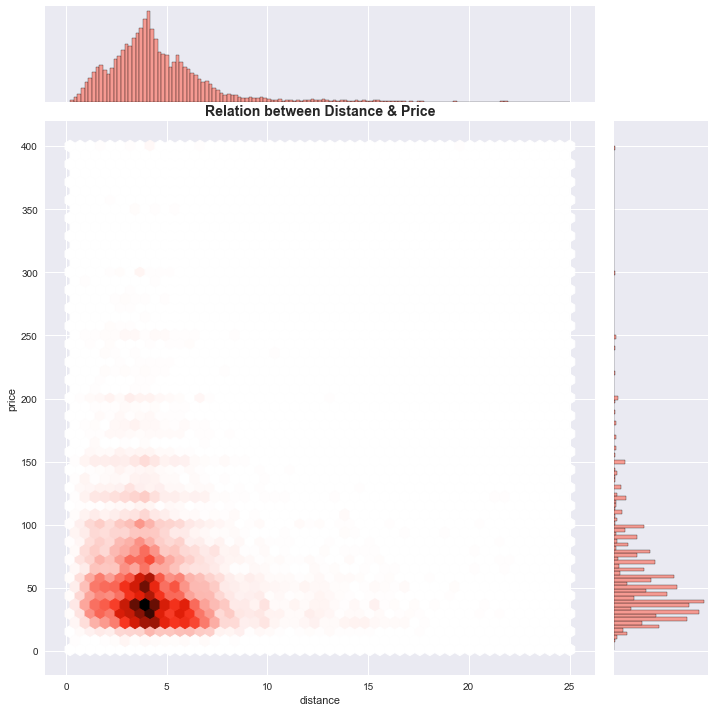

In [20]:
sns.jointplot(x=dataset["distance"], y=dataset["price"], kind="hex", color='#fa8072', height = 10)
plt.title('Relation between Distance & Price', fontsize=14, fontweight='bold');

#### Checking columns with information about neighborhoods

In [21]:
data[['neighbourhood', 'neighbourhood_cleansed','neighbourhood_group_cleansed']].head()

,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,Mitte,Brunnenstr. Süd,Mitte
1,NaN,Prenzlauer Berg Nordwest,Pankow
2,Prenzlauer Berg,Prenzlauer Berg Südwest,Pankow
3,Schöneberg,Schöneberg-Nord,Tempelhof - Schöneberg
4,Prenzlauer Berg,Helmholtzplatz,Pankow


We decide to use only neighbourhood_group_cleansed

Text(0.5, 1.0, '\nMedian Prices by Neighbourhood\n')

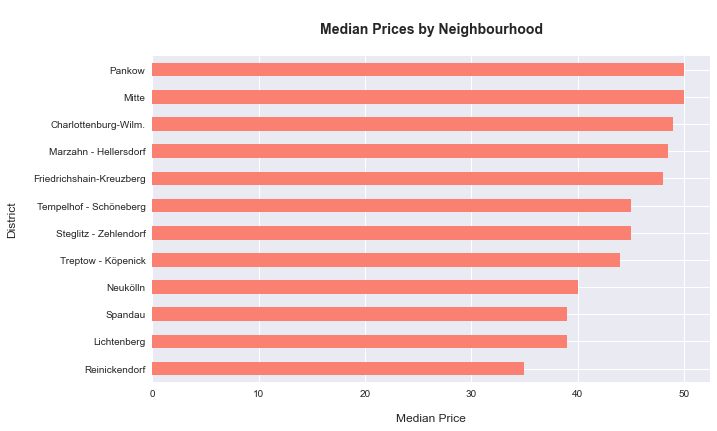

In [22]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(dataset.groupby(dataset['neighbourhood_group_cleansed'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)


df_grouped_distane = pd.DataFrame(dataset.groupby(dataset["neighbourhood_group_cleansed"])["distance"].agg(np.mean))
df_grouped_distane.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                figsize=(10,6), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

In [23]:
# creating the standarized pelette for presenting neighbourhoods on the map

neighbourhoods = list(dataset['neighbourhood_group_cleansed'].unique())
palette= list(sns.color_palette("Paired", len(neighbourhoods)))

colors = dict(zip(neighbourhoods, palette))


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


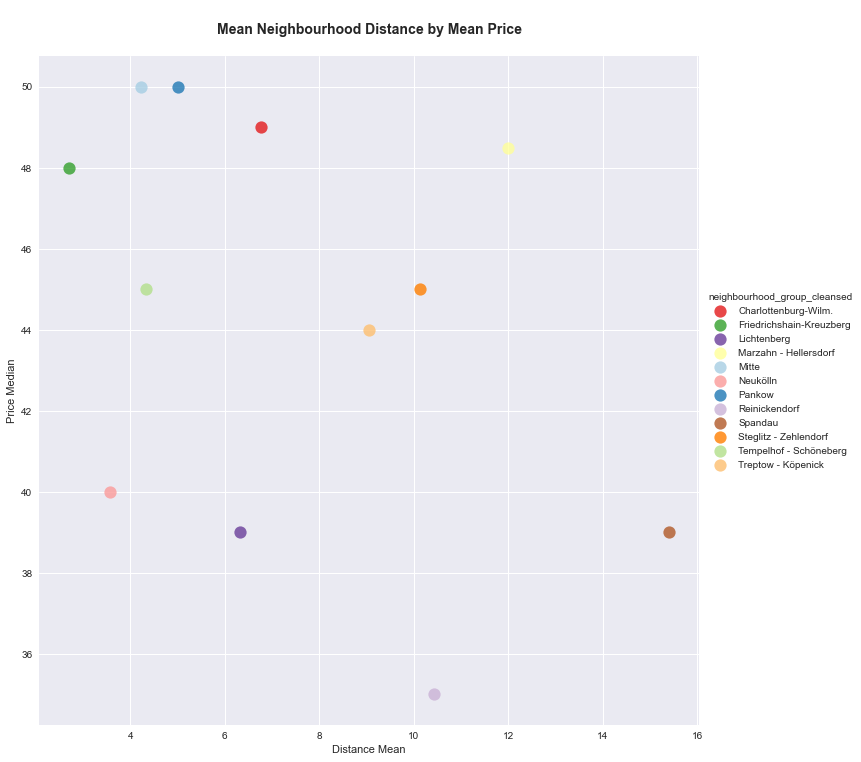

In [24]:
df_grouped_distane.sort_values(by=['neighbourhood_group_cleansed'])
df_grouped.sort_values(by=['neighbourhood_group_cleansed'])

joined = pd.merge(df_grouped_distane, df_grouped, on="neighbourhood_group_cleansed")


sns.lmplot('distance', 'price', data=joined,  hue='neighbourhood_group_cleansed', scatter_kws={"s": 150}, fit_reg=False, height=10, palette=colors)
fig.suptitle('test title')
plt.xlabel('Distance Mean')
plt.ylabel('Price Median')
plt.title('\nMean Neighbourhood Distance by Mean Price\n', fontsize=14, fontweight='bold')
plt.show()

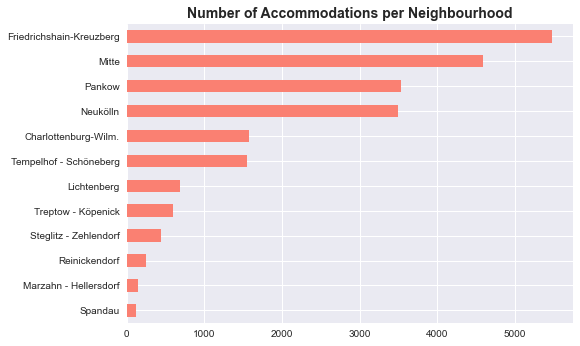

In [25]:
dataset['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='salmon')
plt.title('Number of Accommodations per Neighbourhood', fontsize=14, fontweight='bold');

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


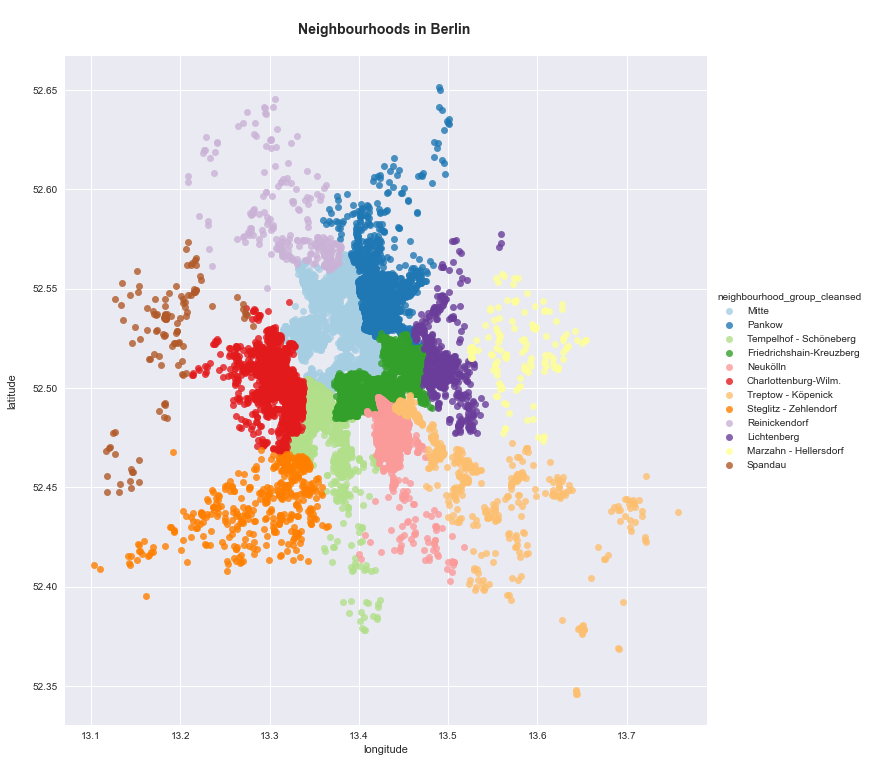

In [26]:
sns.lmplot('longitude', 'latitude', data=dataset,  hue='neighbourhood_group_cleansed', fit_reg=False, height=10,palette="Paired",)

plt.xlabel('longitude')
plt.ylabel('latitude\n')
plt.title('\nNeighbourhoods in Berlin \n', fontsize=14, fontweight='bold')
plt.show()

### Cleaning and processing the column with Amenities

In [27]:
dataset['amenities'].describe()

count     22441
unique    19902
top          {}
freq         71
Name: amenities, dtype: object

In [28]:
from collections import Counter

results = Counter()

counted = dataset['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

In [29]:
list_all_amenities = list(results)

print(f'In the dataset we have {len(list_all_amenities)} diffrent types of amenities')

In the dataset we have 136 diffrent types of amenities


#### 30 most common amenities in Berlin's dataset and their count

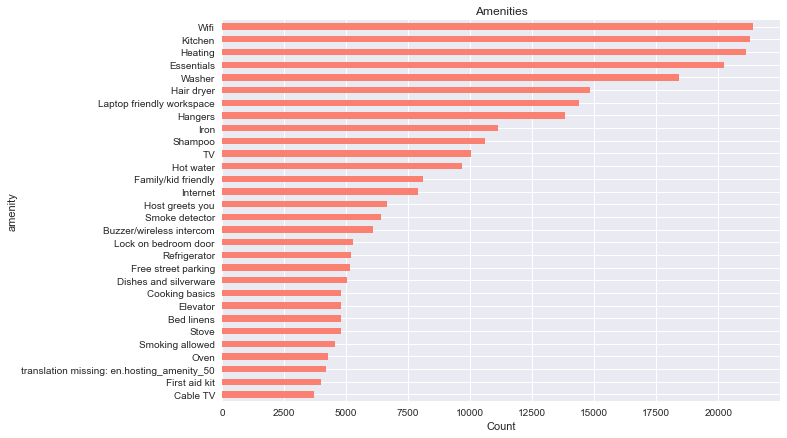

In [30]:
# create a new dataframe
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])
# plot the Top 30
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='salmon',
                                                      title='Amenities')
plt.xlabel('Count');

We decided that the best approach in this situation is addition of the a new column [**amenities_no**] that will store the amount of amenities per each Airbnb.

In [31]:
dataset['amenities_no'] = dataset['amenities'].str.replace('{', '').str.replace('{', '')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',').str.len()

dataset['amenities_no'].describe()

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


count    22441.000000
mean        16.101065
std          8.909784
min          1.000000
25%         10.000000
50%         14.000000
75%         20.000000
max         71.000000
Name: amenities_no, dtype: float64

In [32]:
dataset.drop(['amenities'], axis=1, inplace=True)

In [33]:
print('Number of places where we have NULL values', dataset['amenities_no'].isnull().sum())

Number of places where we have NULL values 0


### Host is Superhost 

In [34]:
print( dataset['host_is_superhost'].head(2), '\n')
print( 'Is null', dataset['host_is_superhost'].isnull().sum(), '\n' )
print('Number of places where we have NULL values', dataset['host_is_superhost'].isnull().sum())

id
2015    t
2695    f
Name: host_is_superhost, dtype: object 

Is null 25 

Number of places where we have NULL values 25


Replacing t with True and f with False

In [35]:
dataset.replace({'host_is_superhost' : {'t' : True, 'f' : False}}, inplace=True)
print( dataset['host_is_superhost'].head(2) )

id
2015     True
2695    False
Name: host_is_superhost, dtype: object


We drop with null values in the host_is_superhost column.

In [36]:
dataset = dataset[pd.notnull(dataset['host_is_superhost'])]

### Bathrooms

In [37]:
print( dataset['bathrooms'].head(2), '\n')
print( 'Is null', dataset['bathrooms'].isnull().sum(), '\n' )
print( dataset["bathrooms"].value_counts().sort_index(), '\n' )

id
2015    1.0
2695    1.0
Name: bathrooms, dtype: float64 

Is null 32 

0.0       40
0.5      102
1.0    19724
1.5     1140
2.0     1239
2.5       68
3.0       47
3.5        2
4.0       10
4.5        1
5.0        1
6.0        1
7.0        2
7.5        2
8.0        2
8.5        3
Name: bathrooms, dtype: int64 



 We assume that places with NULL values represented the places without access to toilet


In [38]:
dataset['bathrooms'].fillna(0, inplace=True)

In [39]:
precentage = dataset.bathrooms.value_counts(normalize=True) * 100
room_no = dataset['bathrooms'].unique()
count = dataset['bathrooms'].value_counts()

d = {'Bathrooms': dataset['bathrooms'].unique(), 'Count': dataset['bathrooms'].value_counts(), '%': dataset.bathrooms.value_counts(normalize=True) * 100}
df = pd.DataFrame(data=d)
df.set_index('Bathrooms', inplace=True)

df.sort_values(by=['Count'], inplace=True)
df.style

,Count,%
Bathrooms,,
4.0,1,0.004461
6.0,1,0.004461
8.5,1,0.004461
3.5,2,0.008922
7.0,2,0.008922
7.5,2,0.008922
8.0,2,0.008922
4.5,3,0.013383
3.0,10,0.044611


Text(0.5, 1.0, '\nMedian Prices by Bathrooms Number\n')

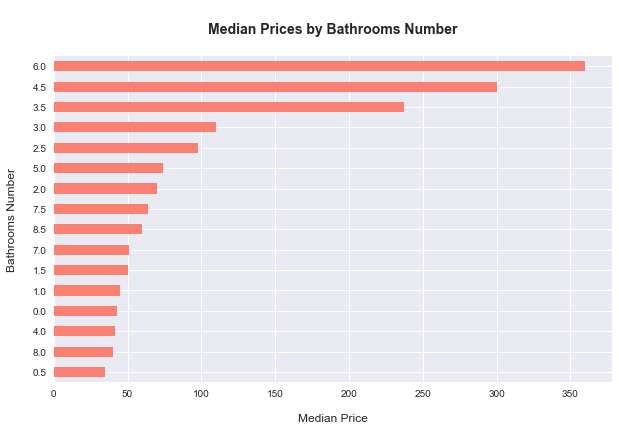

In [40]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(dataset.groupby(dataset['bathrooms'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='bathrooms', y='price', 
                figsize=(10,6), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Bathrooms Number\n', fontsize=12)
plt.title('\nMedian Prices by Bathrooms Number\n', fontsize=14, fontweight='bold')

### Bedrooms

In [41]:
print( dataset['bedrooms'].head(2), '\n')
print('Number of places where we have NULL values', dataset['bedrooms'].isnull().sum(), '\n')
print( dataset["bathrooms"].value_counts().sort_index(), '\n' )

id
2015    1.0
2695    1.0
Name: bedrooms, dtype: float64 

Number of places where we have NULL values 18 

0.0       72
0.5      102
1.0    19724
1.5     1140
2.0     1239
2.5       68
3.0       47
3.5        2
4.0       10
4.5        1
5.0        1
6.0        1
7.0        2
7.5        2
8.0        2
8.5        3
Name: bathrooms, dtype: int64 



Droping rows with nulls in the bedrooms column

In [42]:
dataset.dropna(subset=['bedrooms', ], inplace=True)

Text(0.5, 1.0, '\nMedian Prices by Bedrooms Number\n')

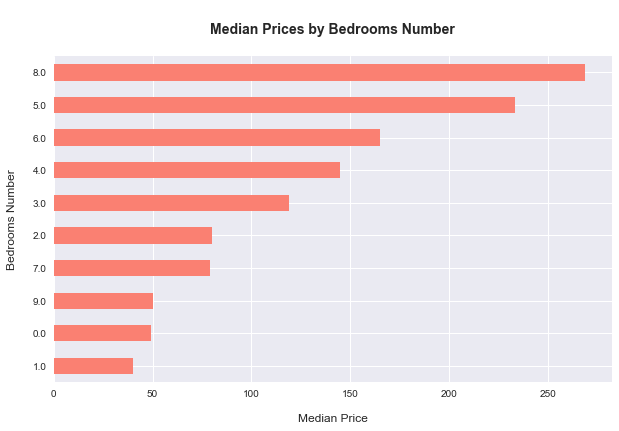

In [43]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(dataset.groupby(dataset['bedrooms'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='bedrooms', y='price', 
                figsize=(10,6), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Bedrooms Number\n', fontsize=12)
plt.title('\nMedian Prices by Bedrooms Number\n', fontsize=14, fontweight='bold')

### Beds

In [44]:
print( dataset['beds'].head(2), '\n')
print('Number of places where we have NULL values', dataset['beds'].isnull().sum(), '\n')
print( dataset["beds"].value_counts().sort_index(), '\n' )

id
2015    2.0
2695    1.0
Name: beds, dtype: float64 

Number of places where we have NULL values 37 

0.0        31
1.0     14257
2.0      5280
3.0      1373
4.0       775
5.0       258
6.0       216
7.0        59
8.0        60
9.0        12
10.0       19
11.0        4
12.0        6
14.0        2
15.0        3
16.0        5
22.0        1
Name: beds, dtype: int64 



We drop the places with 0 and NULL beds

In [48]:
dataset = dataset[(dataset.beds > 0)]


### host_has_profile_pic

In [50]:
print( dataset['host_has_profile_pic'].head(2), '\n')
print('Number of places where we have NULL values', dataset['host_has_profile_pic'].isnull().sum(), '\n')
print( dataset["host_has_profile_pic"].value_counts().sort_index(), '\n' )

id
2015    t
2695    t
Name: host_has_profile_pic, dtype: object 

Number of places where we have NULL values 0 

f       56
t    22274
Name: host_has_profile_pic, dtype: int64 



In [51]:
dataset.replace({'host_has_profile_pic' : {'t' : True, 'f' : False}}, inplace=True)

### accommodates

In [ ]:
How many people can be accomodated in Airbnb

In [52]:
print( dataset['accommodates'].head(2), '\n')
print('Number of places where we have NULL values', dataset['accommodates'].isnull().sum(), '\n')
print( dataset["accommodates"].value_counts().sort_index(), '\n' )

id
2015    3
2695    2
Name: accommodates, dtype: int64 

Number of places where we have NULL values 0 

1      2709
2     12135
3      2470
4      3176
5       694
6       719
7       127
8       148
9        34
10       54
11       15
12       24
13        2
14        7
15        5
16       11
Name: accommodates, dtype: int64 



### instant_bookable

In [56]:
print( dataset['instant_bookable'].head(2), '\n')
print('Number of places where we have NULL values', dataset['instant_bookable'].isnull().sum(), '\n')
print( dataset["instant_bookable"].value_counts().sort_index(), '\n' )

id
2015    f
2695    f
Name: instant_bookable, dtype: object 

Number of places where we have NULL values 0 

f    15399
t     6931
Name: instant_bookable, dtype: int64 



In [58]:
dataset.replace({'instant_bookable' : {'t' : True, 'f' : False}}, inplace=True)

### is_business_travel_ready

In [59]:
print( dataset['is_business_travel_ready'].head(2), '\n')
print('Number of places where we have NULL values', dataset['is_business_travel_ready'].isnull().sum(), '\n')
print( dataset["is_business_travel_ready"].value_counts().sort_index(), '\n' )

id
2015    f
2695    f
Name: is_business_travel_ready, dtype: object 

Number of places where we have NULL values 0 

f    22330
Name: is_business_travel_ready, dtype: int64 



In [61]:
dataset.replace({'is_business_travel_ready' : {'t' : True, 'f' : False}}, inplace=True)

# Finding features that are most impacting the prices of Airbnbs using Linear Regresion & LASSO
#
# BERLIN

In [62]:
['id','host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'beds','amenities_no', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy','host_is_superhost']


['host_has_profile_pic',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'bed_type',
 'beds',
 'amenities',
 'price',
 'cleaning_fee',
 'security_deposit',
 'extra_people',
 'guests_included',
 'minimum_nights',
 'instant_bookable',
 'is_business_travel_ready',
 'cancellation_policy',
 'host_is_superhost']

## Linear regression
### 1st Run
#### Features: bathrooms + bedrooms + beds + distance

In [68]:
model = smf.ols('price ~ bathrooms + bedrooms + beds + distance ', data=dataset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     2350.
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        18:43:02   Log-Likelihood:            -1.1122e+05
No. Observations:               22330   AIC:                         2.225e+05
Df Residuals:                   22325   BIC:                         2.225e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8094      0.931     14.826      0.0

### 2st Run
#### Using the features: 
- bathrooms 
- bedrooms 
- beds
- accommodates
- amenities
- cleaning_fee
- security_deposit
- extra_people
- guests_included
- minimum_nights
- instant_bookable
- is_business_travel_ready
- host_is_superhost

In [91]:
model = smf.ols('price ~ bathrooms + bedrooms + beds + distance + accommodates + cleaning_fee + security_deposit + extra_people + guests_included + minimum_nights + instant_bookable + is_business_travel_ready + host_is_superhost + amenities_no', data=dataset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     1271.
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        18:55:31   Log-Likelihood:            -1.0896e+05
No. Observations:               22330   AIC:                         2.179e+05
Df Residuals:                   22316   BIC:                         2.181e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

### 3rd Run
After running the second time the linear regresion algorithm, we see that we should resigne from taking into the consideration the following:
- instant_bookable
- minimum_nights 
- host_is_superhost
- is_business_travel_ready

In [96]:
model = smf.ols('price ~ bathrooms + bedrooms + beds + distance + accommodates + cleaning_fee + security_deposit + extra_people + guests_included + amenities_no', data=dataset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     1652.
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:55:56   Log-Likelihood:            -1.0896e+05
No. Observations:               22330   AIC:                         2.179e+05
Df Residuals:                   22319   BIC:                         2.180e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.3151      0.904  

In [95]:
model = smf.ols('price ~ bathrooms + bedrooms + beds + distance + accommodates + cleaning_fee + security_deposit + guests_included + is_business_travel_ready + amenities_no', data=dataset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     1834.
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:54:41   Log-Likelihood:            -1.0897e+05
No. Observations:               22330   AIC:                         2.180e+05
Df Residuals:                   22320   BIC:                         2.180e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## Checking the features with LASSO

(0.0007382594846795837,
 39.750448254685224,
 -5.0616868548713745,
 16.071090541123557)

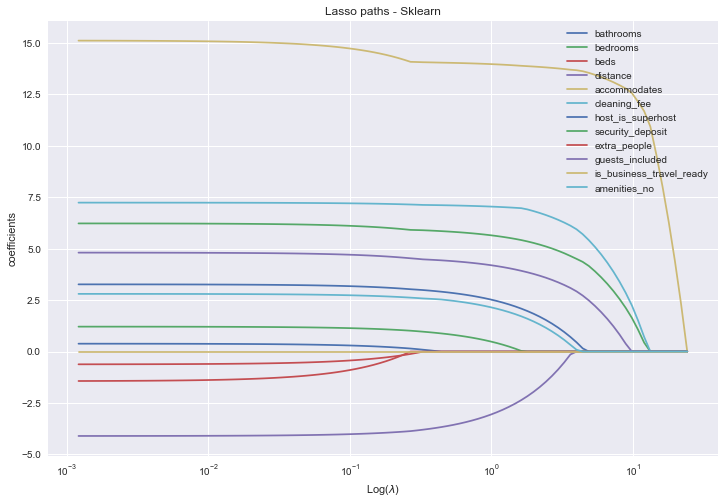

In [106]:
# Lasso 

variables = ['bathrooms','bedrooms','beds','distance','accommodates','cleaning_fee','security_deposit','extra_people','guests_included','is_business_travel_ready','amenities_no']

data_subset = dataset.loc[:, variables + ['price']]

X = data_subset.loc[:,variables]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

In [153]:
# XGBoost

variables = ['bathrooms','bedrooms','beds','distance','accommodates','cleaning_fee','security_deposit','extra_people','guests_included','is_business_travel_ready','amenities_no']

data_subset = dataset.loc[:, variables + ['price']]




random_arr = np.random.randint(low = 0, high = (dataset.shape[0] - 1), size = 1000)

data_subset = data_subset.iloc[random_arr,:]

X = data_subset.loc[:,variables]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that smart stuff
y = np.array(data_subset.price)

model = xgboost.XGBRegressor(n_estimators=10, )
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [154]:
predicted = model.predict(X)
mean_squared_error(y, predicted)

# 360.0616887735761


354.12034957618965

In [155]:
#Playing with Shapley values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [156]:
# high price no: 101
row = 0
X.iloc[row,:]

bathrooms                        1.0
bedrooms                         2.0
beds                             2.0
distance                    5.177508
accommodates                       1
cleaning_fee                    10.0
security_deposit               100.0
extra_people                     0.0
guests_included                    2
is_business_travel_ready       False
amenities_no                      16
Name: 7139359, dtype: object

In [157]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[row,:], X.iloc[row,:])

In [158]:
dataset.shape

(22330, 24)

# xgboost

In [159]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score


variables = ['bathrooms','bedrooms','beds','distance','accommodates','cleaning_fee','security_deposit','extra_people','guests_included','is_business_travel_ready','amenities_no']

data_subset = dataset.loc[:, variables + ['price']]


# split our data
X_train, X_test, y_train, y_test = train_test_split(dataset[variables], dataset['price'], test_size=0.2)


In [160]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [162]:
import xgboost as xgb

# create a baseline
booster = xgb.XGBRegressor()

In [163]:
from sklearn.model_selection import GridSearchCV
# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

# OUTPUT BERLIN {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}

{'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}


In [164]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, 
                           max_depth=7, n_estimators=200)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [165]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 29.072


In [166]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.5164


In [167]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [168]:
params = {'colsample_bytree':0.6, 'gamma':0.2, 'learning_rate':0.05, 'max_depth':7}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [169]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,68.144600,0.104733,68.208448,0.208297
1,65.475108,0.080288,65.602333,0.219265
2,62.927613,0.064086,63.135676,0.168957
3,60.531751,0.046809,60.793934,0.156398
4,58.268316,0.031502,58.589252,0.143495


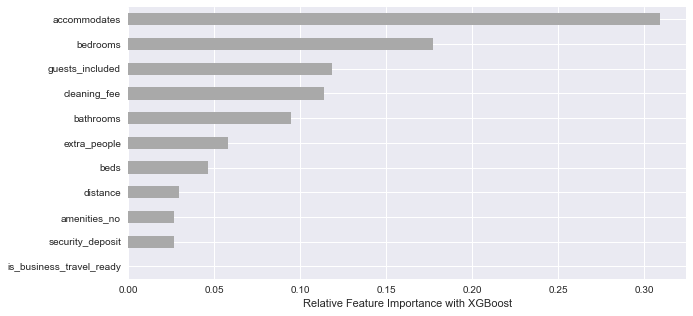

In [172]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=variables)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');